In [55]:
vlib = c("tidyverse", "ggpubr", "patchwork", "ggsci", "viridis",
         "enrichR", "survival", "survminer", "arrow", "ggpmisc")
lapply(vlib, require, character.only = TRUE, quietly = TRUE) |> suppressMessages()

base_dir = "."

setwd(base_dir)

saveRDS.gz <- function(object, file, threads=4) {
  con <- pipe(paste0("pigz -p", threads, " > ", file), "wb")
  saveRDS(object, file = con)
  close(con)
}
readRDS.gz <- function(file, threads = parallel::detectCores()) {
  con <- pipe(paste0("pigz -d -c -p", threads, " ", file))
  object <- readRDS(file = con)
  close(con)
  return(object)
}

df_meta_target = read_delim("assets/file_meta.txt",
                     col_names = c("levels", "time", "cluster_name")) %>% 
                     mutate(prefix_file = paste0(levels, "_", time, "_", cluster_name))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

Rows: 16 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): levels, time, cluster_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
path_map_cis = "assets/02_mashr/joined_all_results.txt.gz"
path_adj_mtx = "assets/SCENIC/adj.csv.gz"
path_compare_studies = "assets/compare_studies/unique_eGenes.txt.gz"
path_gene_modulescore = "assets/wgcna/module_gene_scored.CD8.RNA.txt.gz"
df_map_cis = read_delim(path_map_cis, show_col_types = FALSE)
df_adj_mtx = read_delim(path_adj_mtx, show_col_types = FALSE)
df_gene_modulescore = read_delim(path_gene_modulescore, show_col_types = FALSE)
df_compare_studies = read_delim(path_compare_studies, show_col_types = FALSE)

In [ ]:
# all_data_prep

df_rss = read_delim("scRNA_GRN_scenic/rss_celltype.txt.gz") %>%
  rename(regulon_name = `...1`) %>%
  pivot_longer(cols = 2:ncol(.)) %>%
  filter(value > 0.30) %>%
  mutate(regulon_name = str_replace(regulon_name, "\\(\\+\\)" , ""))

df_adj_mtx_all = left_join(df_rss, df_adj_mtx, by = c("regulon_name" = "TF")) %>%
  select(-value) %>%
  group_by(name, regulon_name) %>%
  mutate(rank_importance = rank(importance) / n())

df_map_cis_all = df_map_cis %>%
  group_by(phenotype_id, condition) %>%
  select(phenotype_id, condition, lfsr, PosteriorMean, PosteriorSD) %>%
  top_n(-lfsr, n = 1) %>%
  mutate(eGene = ifelse(lfsr < 0.05, "eGene", "not eGene")) %>%
  left_join(df_meta_target, by = c("condition" = "prefix_file")) %>%
  mutate(condition = str_sub(condition, 9, -1)) %>%
  mutate(condition = ifelse(grepl("1st", condition),
    paste0("treatment_", cluster_name),
    paste0("baseline_", cluster_name)
  )
  )

df_forplot_all = left_join(
  df_adj_mtx_all,
  df_map_cis_all,
  by = c("name" = "cluster_name", "target" = "phenotype_id")
) %>%
  na.omit()

In [ ]:
# filtering module
c_cluster = c("CD8")
c_regulon = c("TBX21")
c_module = c("brown")

c_specific_regulon = df_rss %>% filter(name == c_cluster) %>% pull(regulon_name)

df_adj_mtx_filtered = df_adj_mtx %>%
  filter(TF %in% c_regulon) %>%
  group_by(TF) %>%
  mutate(rank_importance = rank(importance) / n())

df_map_cis_filtered = df_map_cis_all %>%
  dplyr::filter(grepl(c_cluster, condition))

df_gene_modulescore_filtered = df_gene_modulescore %>%
  filter(color %in% c_module) %>%
  group_by(color) %>%
  mutate(rank_module = rank(value) / n())

df_joinned_forPlot = full_join(
  df_adj_mtx_filtered,
  df_gene_modulescore_filtered,
  by = c("target" = "gene_name")
) %>%
  select(target, TF, importance, rank_importance, color, value, rank_module) %>%
  rename(phenotype_id = target)

df_joinned_forPlot %>% head()

In [ ]:
df_gene_modulescore_filtered = df_gene_modulescore %>%
  group_by(color) %>%
  mutate(rank_module = rank(value) / n())

df_joinned_forPlot = full_join(
  df_adj_mtx_filtered,
  df_gene_modulescore_filtered,
  by = c("target" = "gene_name")
) %>%
  select(target, TF, importance, rank_importance, color, value, rank_module) %>%
  rename(phenotype_id = target)


### figure 5A

In [ ]:
df_joined_forPlot_Ours = left_join(
  df_joinned_forPlot,
  df_map_cis_filtered,
  by = "phenotype_id"
) %>%
  filter(!is.na(condition))

p5a = df_joined_forPlot_Ours %>%
  ggplot(aes(x = eGene, y = rank_module)) +
  #ggplot(aes(x = eGene, y = importance)) +
  facet_wrap(~condition) +
  geom_violin(aes(fill = eGene), width = 0.60, color = "#FFFFFF") +
  geom_boxplot(width = 0.25, alpha = 0.95) +
  stat_compare_means(
     hjust = -0.5,
     aes(label = paste0("p = ", after_stat(p.format)))
  ) +
  ggtitle("A") +
  ylab("Rank in module") +
  scale_fill_manual(values = c("#708be9a4", "grey90")) +
  scale_y_continuous(breaks = c(0, 0.5, 1)) +
  theme_pubr(legend = "none") +
  theme(
    axis.title = element_text(size = 15),
    axis.text = element_text(size = 12.5),
    strip.text = element_text(size = 14),
    strip.background = element_rect(fill = NA)
  )


In [ ]:
list_onek1k = list.files(
  "correlation_mapping_onek1k/eqtl_table/",
  "eqtl_table.parquet",
  full.names = T)
list_onek1k = lapply(list_onek1k, read_parquet)
names(list_onek1k) = c("CD4_TEM", 
                             "CD4_Naive", 
                             "CD4_SOX4",
                             "CD8_TEM",
                             "CD8_Naive_TCM",
                             "CD8_S100B_T",
                             "Classic_Mono",
                             "DC",
                             "Memory_B",
                             "Naive_B",
                             "NK",
                             "NK_recruiting",
                             "Nonclassic_Mono",
                             "Plasma")
df_onek1k = list_onek1k %>% 
  bind_rows(.id = "cluster") %>% 
  #filter(FDR < 0.05) %>% 
  ungroup() %>% 
  distinct(GENE, cluster, .keep_all = TRUE)

df_onek1k = df_onek1k %>% 
  mutate(onek1k_significance = ifelse(FDR < 0.05, "eGene", "non-eGene")) %>%
  select(GENE, cluster, onek1k_significance, FDR) %>%
  dplyr::rename(phenotype_id = GENE, onek1k_fdr = FDR, onek1k_cluster = cluster)

  df_onek1k_cd8 = df_onek1k %>%
  filter(grepl("CD8", onek1k_cluster)) 

In [ ]:
df_joined_forPlot_onek1k = left_join(df_joinned_forPlot, df_onek1k_cd8, by = "phenotype_id") %>%
  filter(!is.na(onek1k_significance)) %>%
  rename(eGene = onek1k_significance)
#df_joined_forPlot_onek1k

### figure 5B

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 9, repr.plot.res = 200)
p5_11k = df_joined_forPlot_onek1k %>%
  ggplot(aes(x = eGene, y = rank_module)) +
  #ggplot(aes(x = eGene, y = importance)) +
  facet_wrap(~onek1k_cluster) +
  geom_violin(aes(fill = eGene), width = 0.60, color = "#FFFFFF") +
  geom_boxplot(width = 0.25, alpha = 0.95) +
  stat_compare_means(
     hjust = -0.5,
     aes(label = paste0("P = ", after_stat(p.format)))
  ) +
  ggtitle("C") +
  ylab("Rank in module") +
  scale_fill_manual(values = c("#708be9a4", "grey90")) +
  scale_y_continuous(breaks = c(0, 0.5, 1)) +
  theme_pubr(legend = "none") +
  theme(
    axis.title = element_text(size = 15),
    axis.text = element_text(size = 12.5),
    strip.text = element_text(size = 14),
    strip.background = element_rect(fill = NA)
  )
ggsave("figure_prep/pRank_onek1k_eQTLeffect_estimate.pdf",  p5_11k, width = 8.5, height = 3.75)

### figure 5C

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
pbeta = df_betaDistribution_forPlot_eGene %>%
  mutate(rank_decile = as.factor(rank_decile)) %>%
  ggplot(aes(x = rank_module * 10, y = log2(abs(PosteriorMean)))) +
  #geom_jitter(
  #  data = df_betaDistribution_forPlot_noteGene,
  #  aes(x = rank_decile),
  #  color = "grey60", shape = 16, alpha = 0.4
#  ) +
  stat_poly_eq(
    formula = (x) / 10 ~ y,
    aes(
      label = paste(
        after_stat(eq.label), "P ", format(p.value, 3),
        sep = "*`,`~"
      )
    ),
    vjust = 0.1,
    parse = TRUE
  ) +
  geom_jitter(
    aes(x = rank_decile, color = "eGene"),
    color = "#385ee68f", shape = 16
  ) +
    scale_x_discrete() +
  geom_boxplot(
    aes(x = as.factor(rank_decile)),
    outlier.shape = NA,
    width = 0.75,
    alpha = 0.5,
    linewidth = 0.5
  ) +
  geom_smooth(
    aes(x = as.numeric(rank_module) * 10 + 0.5, y =  log2(abs(PosteriorMean))),
    method = "lm",
    se = FALSE,
    color = "#ca2f2f",
    linewidth = 0.75,
    alpha = 0.8
  ) +
  facet_wrap(~condition, nrow = 1) +
  xlab("Decile of module rank") +
  ylab("log2 of Absolute effect size") +
  theme_pubr(legend = "top") +
  theme(
    axis.title = element_text(size = 15),
    axis.text = element_text(size = 13),
    strip.text = element_text(size = 14),
    strip.background = element_rect(fill = NA)
  )


### figure 5D

In [4]:
df_map_cis = read_delim("assets/02_mashr/joined_all_results.txt.gz")
df_eGene = df_map_cis %>% filter(lfsr < 0.05)
c_cluster ="CD8"
c_eGene = df_eGene %>% filter(grepl(c_cluster, condition)) %>% distinct(phenotype_id) %>% pull()

Rows: 69897 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): phenotype_id, variant_id, condition, prefix_file, name
dbl (10): lfsr, PosteriorMean, PosteriorSD, start_distance, af, ma_samples, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
library(fgsea)
library(msigdbr)

df_CD8_module_scored = read_delim("analysis/assets/wgcna/module_gene_scored.CD8.RNA.txt.gz")

m_df<- msigdbr(species = "Homo sapiens", category = "H") 
fgsea_sets<- m_df %>% split(x = .$gene_symbol, f = .$gs_name)


ERROR: Error in library(fgsea): there is no package called ‘fgsea’


In [ ]:
res = df_CD8_module_scored %>%
  filter(color == "brown", gene_name %in% c_eGene) %>%
  select(gene_name, value) %>% deframe()
df_gsea_res_CD8_egene = fgsea(fgsea_sets, res, scoreType = "pos")

pgsea_3 = df_gsea_res_CD8_egene %>% arrange(padj) %>% top_n(n = 10, -pval) %>% 
  mutate(pathway = str_sub(pathway, 10, -1)) %>%
  mutate(pathway = str_replace_all(pathway, "_", " ")) %>%
  mutate(name = "CD8") %>%
  mutate(pathway = factor(pathway, levels = rev(unique(.$pathway)))) %>% 
  mutate(color_size = ifelse(padj > 0.05 , NA, size)) %>%
  ggplot(aes(x =  NES, size = -log10(padj), y = pathway, color = color_size)) + 
  geom_point() + scale_color_gradient2(low ="#BCE4D8",
                                       mid = "#3E9AB4",
                                       high = "#2C5985",
                                       midpoint = 20,
                                       na.value = "grey70") +
  theme_pubr(legend = "right") +
  facet_wrap(~name)+
  theme(strip.background = element_rect(fill= NA, linewidth = 1),
        strip.text = element_text(size = 13)) +
  scale_x_continuous(limits = c(1,2.5), breaks = c(1,2.0, 2.5))


pgsea_3 %>% ggsave("figure_prep/p_DME_eQTLsubset_module.pdf",
                   .,
                   width = 16,
                   height = 8,
                   units = "cm",
                   dpi = 300)
 df_gsea_res_CD8_egene %>% arrange(padj) %>% top_n(n = 10, -pval) 

In [12]:
### PRF1 - Brown analysis


library(pgenlibr)
pvar <- pgenlibr::NewPvar("/data/nfs_dell/project_HS/202310-sceqtl_v6/pseudobulk_pipeline/plink_subset/temp_plink_maf01_HWEe5_geno03_mind03.pvar")
pgen <- pgenlibr::NewPgen("/data/nfs_dell/project_HS/202310-sceqtl_v6/pseudobulk_pipeline/plink_subset/temp_plink_maf01_HWEe5_geno03_mind03.pgen",
                          pvar = pvar)
sample_id = read_delim("/data/nfs_dell/project_HS/202310-sceqtl_v6/pseudobulk_pipeline/plink_subset/temp_plink_maf01_HWEe5_geno03_mind03.psam") %>%
  pull(IID)
gtf = read_delim("assets/gencode.v43.basic.tss_bed.txt")

c_colors = c(
  "B" = "#C0392BFF",
  "CD4" = "#D35400FF", 
  "CD8" = "#F39C12FF",
  "DC" = "#27AE60FF",
  "Mono" = "#16A085FF",
  "NK" = "#2980B9FF",
  "Other" = "#8E44ADFF",
  "Other_T" = "#2C3E50FF"
)
  

Rows: 73 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): #FID, IID
dbl (1): SEX

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 59582 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): #chr, gene_id
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
df_map_cis %>% filter(phenotype_id == "PRF1")

phenotype_id,variant_id,condition,lfsr,PosteriorMean,PosteriorSD,start_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,prefix_file,name
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
PRF1,chr10:69735970:T:G,anno_l1_1st_CD4,0.209034051,-0.029802553,0.04004159,-866789,0.4863014,51,71,6.035769e-01,-0.087763600,0.16748577,anno_l1_1st_CD4,PRF1_chr10:69735970:T:G
PRF1,chr10:69735970:T:G,anno_l1_1st_CD8,0.333484101,-0.023911874,0.05641304,-866789,0.4863014,51,71,9.423380e-01,-0.006025891,0.08271322,anno_l1_1st_CD8,PRF1_chr10:69735970:T:G
PRF1,chr10:69735970:T:G,anno_l1_1st_NK,0.141247984,0.060187661,0.05617849,-866789,0.4863014,51,71,1.074077e-01,0.122750774,0.07428858,anno_l1_1st_NK,PRF1_chr10:69735970:T:G
PRF1,chr10:69735970:T:G,anno_l1_1st_Other_T,0.422185301,-0.006415592,0.03289110,-866789,0.4863014,51,71,6.644914e-01,-0.035706215,0.08162840,anno_l1_1st_Other_T,PRF1_chr10:69735970:T:G
PRF1,chr10:69735970:T:G,anno_l1_1st_Other,0.486038533,-0.001891604,0.04652818,-866789,0.4863014,51,71,5.969028e-01,-0.085485980,0.16016741,anno_l1_1st_Other,PRF1_chr10:69735970:T:G
PRF1,chr10:69735970:T:G,anno_l1_base_CD4,0.017094407,-0.097439906,0.05049797,-866789,0.4863014,51,71,3.597677e-02,-0.317120731,0.14555122,anno_l1_base_CD4,PRF1_chr10:69735970:T:G
PRF1,chr10:69735970:T:G,anno_l1_base_CD8,0.001641491,-0.234377699,0.06918603,-866789,0.4863014,51,71,3.104559e-05,-0.328212768,0.06892703,anno_l1_base_CD8,PRF1_chr10:69735970:T:G
PRF1,chr10:69735970:T:G,anno_l1_base_NK,0.309839190,0.038511520,0.07487246,-866789,0.4863014,51,71,3.156048e-01,0.102185585,0.10040692,anno_l1_base_NK,PRF1_chr10:69735970:T:G
PRF1,chr10:69735970:T:G,anno_l1_base_Other_T,0.290688632,-0.016875830,0.03428523,-866789,0.4863014,51,71,4.238670e-01,-0.070020802,0.08655930,anno_l1_base_Other_T,PRF1_chr10:69735970:T:G


In [62]:
name = "PRF1_chr10:69735970:T:G" # example.
target_id = str_split(name, "_")[[1]][1]
target_variant  = str_split(name, "_")[[1]][2]
target_chr = gtf %>% filter(gene_id == target_id) %>% pull(`#chr`)

var_id = c()
for (each in target_variant){
  var_id = append(var_id, GetVariantsById(pvar, each))
}

geno_mat <- pgenlibr::ReadList(pgen, var_id)
colnames(geno_mat) = target_variant
rownames(geno_mat) = sample_id

allele_extraction = str_split(target_variant, ":")
lab = c(paste0(allele_extraction[[1]][3],allele_extraction[[1]][3]),
        paste0(allele_extraction[[1]][3],allele_extraction[[1]][4]),
        paste0(allele_extraction[[1]][4],allele_extraction[[1]][4]))

In [63]:
df_geno = geno_mat %>% as.data.frame() %>% rename(variant = all_of(target_variant)) %>% rownames_to_column("sample") 

In [64]:
df_geno %>% group_by(variant) %>% summarise(n = n())

variant,n
<dbl>,<int>
0,22
1,31
2,20


Rows: 78090 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): CellID, Response, time, sample, anno_l2
dbl (11): pink, magenta, brown, black, yellow, turquoise, green, red, purple...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(sample)`


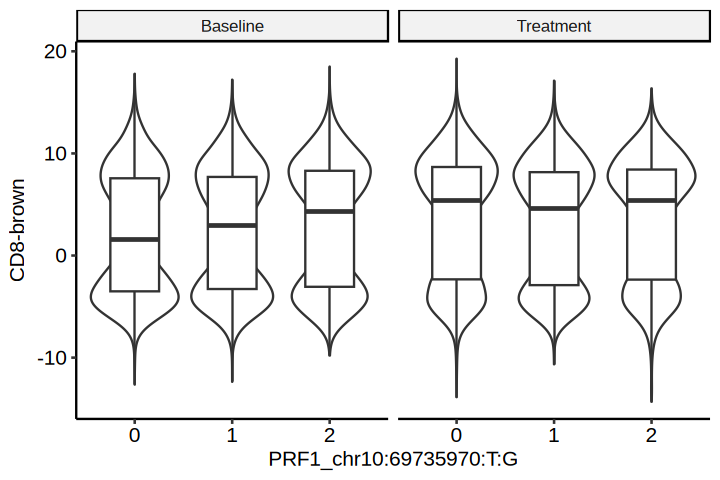

In [65]:
options(repr.plot.width = 6, repr.plot.height = 4)
read_delim("assets/wgcna/CD8_MEs.txt.gz") %>% left_join(df_geno) %>% 
mutate(time = factor(ifelse(time == "1st", "Treatment", "Baseline"), levels = c("Baseline", "Treatment"))) %>%
  ggplot(aes(x = as.factor(variant), y = brown)) + geom_violin() + geom_boxplot(width = 0.5) + facet_wrap(~time) + xlab(name) + ylab('CD8-brown') + theme_pubr()

In [75]:
left_join(df_gene_modulescore, df_map_cis, by = c("gene_name" = "phenotype_id")) %>% filter(color == "brown", lfsr < 0.05, grepl("CD8", condition))

gene_name,color,value,variant_id,condition,lfsr,PosteriorMean,PosteriorSD,start_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,prefix_file,name
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GZMH,brown,0.8776770,chr14:24702444:T:C,anno_l1_1st_CD8,1.662423e-02,-0.18113661,0.08260264,92745,0.21232876,28,31,1.510541e-01,-0.1608977,0.10960881,anno_l1_1st_CD8,GZMH_chr14:24702444:T:C
PRF1,brown,0.7786047,chr10:69735970:T:G,anno_l1_base_CD8,1.641491e-03,-0.23437770,0.06918603,-866789,0.48630136,51,71,3.104559e-05,-0.3282128,0.06892703,anno_l1_base_CD8,PRF1_chr10:69735970:T:G
GZMB,brown,0.7752229,chr14:25054443:G:A,anno_l1_1st_CD8,1.964842e-02,-0.21060884,0.10750558,420176,0.24657534,32,36,1.632731e-01,-0.2034576,0.14286761,anno_l1_1st_CD8,GZMB_chr14:25054443:G:A
FGFBP2,brown,0.7745047,chr4:15967286:T:G,anno_l1_1st_CD8,1.384532e-02,-0.17435370,0.08249012,-2023,0.28082192,36,41,1.598500e-01,-0.1929838,0.13437974,anno_l1_1st_CD8,FGFBP2_chr4:15967286:T:G
PLEK,brown,0.6789833,chr2:68400136:G:A,anno_l1_1st_CD8,3.767953e-06,-0.50536764,0.12412793,34854,0.23287672,30,34,3.344425e-04,-0.5427314,0.13649520,anno_l1_1st_CD8,PLEK_chr2:68400136:G:A
PLEK,brown,0.6789833,chr2:68400136:G:A,anno_l1_base_CD8,4.819690e-04,-0.34326799,0.10252254,34854,0.23287672,30,34,4.687255e-03,-0.3633258,0.12050005,anno_l1_base_CD8,PLEK_chr2:68400136:G:A
HLA-C,brown,0.6789025,chr6:31299841:A:G,anno_l1_1st_CD8,6.584726e-11,0.50499364,0.07646057,27711,0.23972602,31,35,9.957161e-07,0.6083001,0.10282031,anno_l1_1st_CD8,HLA-C_chr6:31299841:A:G
HLA-C,brown,0.6789025,chr6:31299841:A:G,anno_l1_base_CD8,7.149257e-09,0.48353362,0.06989233,27711,0.23972602,31,35,1.594933e-05,0.5432719,0.10908120,anno_l1_base_CD8,HLA-C_chr6:31299841:A:G
B2M,brown,0.6785125,chr15:43986800:G:GT,anno_l1_base_CD8,3.090838e-02,0.08484327,0.04659903,-724558,0.09589041,14,14,1.147587e-01,0.1056914,0.06539061,anno_l1_base_CD8,B2M_chr15:43986800:G:GT
